# GEOL351 Lab 9
# Multiple Climate Equilibria: Icehouse vs Hothouse
## Student Name :  [WRITE YOUR NAME HERE]

In this lab, you will explore, tweak and tinker with the zero-dimensional climate model seen in class. This model, and much of the following lab, is strongly inspired by Ray Pierrehumbert's excellent book, [Principles of Planetary Climate](http://www.cambridge.org/raypierre).

We will be working in the iPython / Jupyter notebook system. We like these because they are a form of literate programming in which we can mix textbook instruction and explanations with code that can also be run and edited. You will be asked to run some cells, tweak parameters and write down results. **Please save the resulting notebook once you are done; this is what you will be handing out**.

Think you can't code? Be reassured, we will guide you by the hand. The beauty of iPython notebooks is that they integrate the code very naturally in a scholarly document, and the most you will have to do is sliughtly edit the code and watch how this affects the results. This should allow you to focus on the dynamics, not so much the informatics. 

Let's start with a little preliminary learning.

## Part 0: iPython notebooks 

### Python

Haven't you always wanted to code? Thanks to [Python](https://www.python.org/), anyone with a modicum of common sense and a keyboard can do so. Python is a high-level language whose syntax makes it very difficult to be a bad programmer. For a few of the many reasons why you should pick up Python before your education is over, read [this](http://www.nature.com/news/programming-pick-up-python-1.16833?WT.ec_id=NATURE-20150206).   


### Markdown

You can document your iPython notebooks by making some cells into [Markdown Website](http://daringfireball.net/projects/markdown/) cells. Markdown is a way of formatting text that is supposed to be almost as readable un-rendered as when it is tidied up.  If you look at the **Markdown** cells as source code (by double-clicking on them) you will see how the raw text looks. If you can deal with the unwieldy and ugly Microsoft Word, you can certainly handle Markdown. 

You will be expected to turn in your lab for grading as a notebook, so you should write all your notes, observations, and concluions in the notebook. 

### Maths

In a browser, you can render beautiful equations using a javascript tool called [Mathjax Website](http://docs.mathjax.org) which is build into the iPython notebooks. It is based on a [LaTeX](https://www.latex-project.org/) engine,  You can build in symbols to your text such as $\pi$ and $\epsilon$ if you use the \$ signs to indicate where your equations begin and end, and you know enough $\LaTeX$ [try it here !](http://www.codecogs.com/latex/eqneditor.php) to get by.


Equations in 'display' mode are written like this (again look at the source for this cell to see what is used)

\\[ e^{i\pi} + 1 = 0 \\]

or even like this

\begin{equation}
%%
    \nabla^4 \psi = \frac{\partial T}{\partial x}
%%    
\end{equation}

Go back to the rendered form of the cell by 'running' it.



## A zero-dimensional climate model

The dynamics are governed by conservation of energy, which takes the form of an ordinary linear equation:

$ C_s \frac{d T_e}{dt} = \left(1 -\alpha(T_e) \right) \frac{S_{\circ}}{4} -   \sigma {T_e}^4 \equiv G(T_e)$ [Eq (1)]

with $T_e$ the *emission temperature* and the albedo $\alpha$ is a nonlinear function of climate state (indexed by $T_e$, which is therefore the *state variable* for the system).  $\alpha$ is given by :

$\alpha(T) = \begin{cases} 
\alpha_i & \text{for } T \leq T_i \\
\alpha_0 + (\alpha_i- \alpha_0) \frac{(T-T_0)^2}{(T_i-T_0)^2} & \text{for } T_i < T < T_0 \\
\alpha_0 & \text{for } T \geq T_0 \\
 \end{cases} $ [Eq (2)]

By definition, the emission of radiation to outer space takes place at some height $z_rad$ above the ground, corresponding to a pressure $p_\text{rad}$. The greenhouse effect can be understood as a tendency to raise the emission level, hence lower $p_\text{rad}$. Choosing $p_\text{rad} = 670 mb$ yields a climate not to dissimilar to our current one. 

** Question 1: ** Is the planet's emission of electromagnetic radiation in the longwave or shortwave domain? What does this depend on?


** Answer 1 ** : PLEASE WRITE YOUR ANSWER HERE

The other relation we need is the relationship between the surface temperature $T_s$ and $T_e$:

 $T_s = T_e \left(\frac{p_s}{p_\text{rad}} \right)^{\kappa}$ where  $\kappa = 2/7$
 
 If we assume that $p_s$ and $p_\text{rad}$ are both constant, working with $T_e$ is equivalent to working with $T_s$, which we shall do from now on. 

Now, in order to get going, we need to set up a few preliminaries. First, let's import other bits and pieces of Python code to save us some time.

In [2]:
%matplotlib inline  
# ensures that graphics display in the notebook 

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("./CoursewareModules")

from ClimateUtilities import *  # import Ray Pierrehumbert's climate utilities
import phys
import seaborn as sns

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(print "numpy not found. Using Numeric instead")? (ClimateUtilities.py, line 54)

## Outgoing Long-wave radiation 
Let us define a function that will compute outgoing longwave emission from the planet for a given emission temperature $T$ (dropping the subscript for convenience).  

In [2]:
def OLR(T,param=None):
    pRad = param
    return phys.sigma * (T**4.)*(pRad/1000.)**(4.*2./7.)

The radiating pressure pRad, in mb, is passed as the
optional second parameter. It can be used to
pass parameters of other OLR expressions, e.g. CO2 concentrations. Let's see how this depends on T. 

## Incoming solar radiation 

Similarly, let's define a function for the albedo, $\alpha(T)$. 

In [3]:
def albedo(T):
    if T < T1:
        return alpha_ice
    elif (T >= T1)&(T<=T2):
        r = (T-T2)**2/(T2-T1)**2
        return alpha_0 + (alpha_ice - alpha_0)*r
    else:
        return alpha_0

Notice how the function uses "global" arguments  alpha_ice, alpha_ice, T1, T2. We need to define those for the function to work. Let's do this, along with defining pRad. 

In [4]:
L = 1.*1370. 
alpha_ice = .6
alpha_0 = .2
T1 = 260. # in Kelvins
T2 = 290. # in Kelvins
pRad = 1000. # in mb

The next cell generates lists of values for OLR, the next flux, and the incoming radiation given a range of temperature values from 200 to 340 K.  

In [5]:
Tlist = [200.+ 2.*i for i in range(70)]
SabsList = []
OLRlist = []
NetFluxlist = []
Glist = []
aList = []

for T in Tlist:
    aList.append(albedo(T))  # albedo function
    SabsList.append((L/4.)*(1.-albedo(T))) # incident solar values
    OLRlist.append(OLR(T,pRad)) # outgoing longwave emissions
    NetFluxlist.append((L/4.)*(1.-albedo(T)) - OLR(T,pRad))  # net flux
    Glist.append(4.*OLR(T,pRad)/(1.-albedo(T)))  # balance function

Time to plot a few things! First, the albedo:

(0, 0.8)

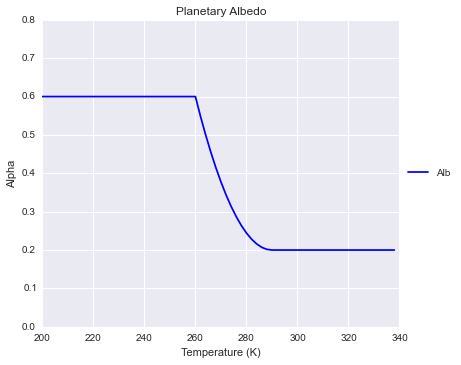

In [6]:
c1 = Curve()
c1.addCurve(Tlist)
c1.addCurve(aList,'Albedo','Alb')
c1.Xlabel = 'Temperature (K)'
c1.Ylabel = 'Alpha'
c1.PlotTitle = 'Planetary Albedo'
w1 = plot(c1)
plt.ylim((0, 0.8))


## Energy Balance
Next, let's look at energy balance. What's coming in, what's going out?

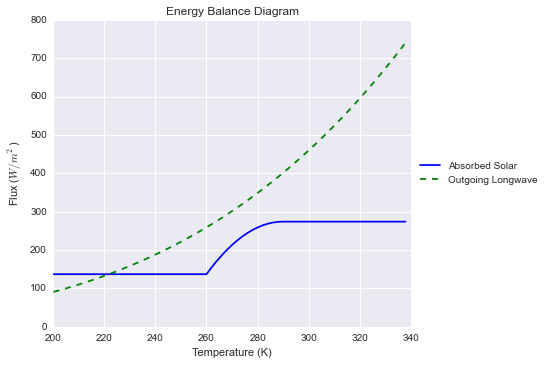

In [7]:
c1 = Curve()
c1.addCurve(Tlist)
c1.addCurve(SabsList,'Sabs','Absorbed Solar')
c1.addCurve(OLRlist,'OLR','Outgoing Longwave')
c1.Xlabel = 'Temperature (K)'
c1.Ylabel = 'Flux ($W/m^2$)'
c1.PlotTitle = 'Energy Balance Diagram'
w1 = plot(c1)

Another way to look at this is to graph the difference between these curves (which we called $G(T)$ above)

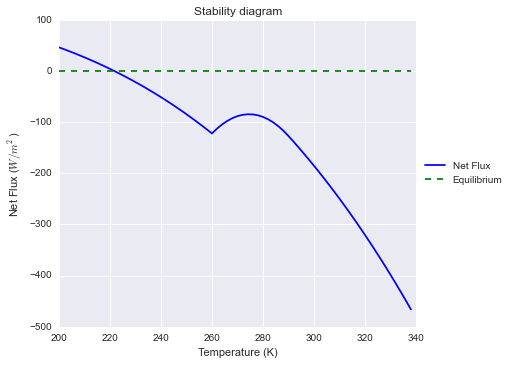

In [8]:
c2 = Curve()
c2.addCurve(Tlist)
c2.addCurve(NetFluxlist,'Net','Net Flux')
c2.addCurve([0. for i in range(len(Glist))],'Zero','Equilibrium')
c2.Xlabel = 'Temperature (K)'
c2.Ylabel = 'Net Flux ($W/m^2$)'
c2.PlotTitle = 'Stability diagram'
w2 = plot(c2)


### Question 2: 
Solving graphically, **for which values of the solar luminosity L do we get 1, 2 or 3 equilibria?**  

### Answer 2: 
Write your answer here

What you just did, informally, is to draw a **bifurcation diagram** for the system. Now we can be a lot smarter about this, and instead of typing like monkeys hoping to recreate Shakespeare (or Pierrehumbert as the case may be), we can try to solve for $G(T) = 0$.

### Question 3: 
**Setting $G(T) = 0$, derive an analytical expression for $L_{eq}$, the value of $L$ for which incoming solar radiation balances exactly outgoing longwave radiation. **

### Answer 3:

Write your answer here

## Solar Bifurcation

Next we plot this value as a function of $T$. However, let's introduce a little twist: $T$ of course, is a consequence of the value of L and pRad, not a cause of it. So we should switch the X and Y axes so that we get $T = f(L)$, not $ L = f(T)$.  

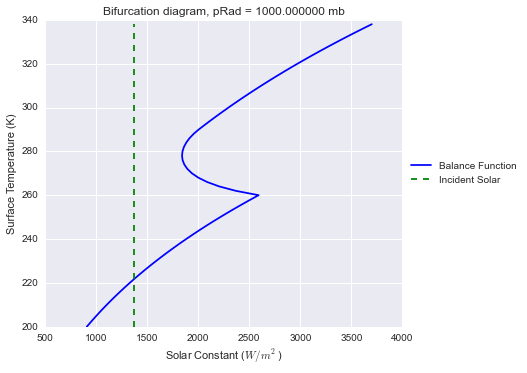

In [9]:
c3 = Curve()
c3.addCurve(Tlist)
c3.addCurve(Glist,'G','Balance Function')
c3.addCurve([L for i in range(len(Glist))],'S','Incident Solar')
c3.switchXY = True #Switches axis so it looks like a hysteresis plot
c3.PlotTitle = 'Bifurcation diagram, pRad = %f mb'%pRad
c3.Xlabel = 'Surface Temperature (K)'
c3.Ylabel = 'Solar Constant ($W/m^2$)'
w3 = plot(c3)

Once again, wherever this balance function (blue curve) inersects the incident solar radiation (dashed green curve), we get one or more equilibrium temperature(s). From this it is easy to find the values of the solar constant for which we can have 1, 2 or 3 equilibria. Note that some of the branches in this diagram are unstable.  For instance, as you vary L from 1370 up to 3000, say, at some point you will leave the lower branch and land abruptly and without warning, on the upper branch.  This is one reason why bifurcations are relevant to climate risk assessment.

### Question 4 
The current greenhouse effect yields a radiative pressure pRad in the neighborhood of 670mb. Repeat the calculations above for this value of $p_{Rad}$, (it will be cleaner if you copy and paste the relevant cells below).
** For which value of L, approximately, would we enter a stable snowball state? **
(to answer this, redraw the bifurcation diagram above with $p_{Rad}=670$mb. For $L = 1370 W.m^{-2}$ you should find 3 possible states. Assume that you are on the upper, toasty branch. For which value of $L$ would you fall onto the lower, icy branch?) 

In [10]:
# perform your new calculations here

### Answer 4 
write your answer here

Finally, we could ask what kind of climate would be obtained by varying the atmosphere's opacity to outgoing longwave radiation (i.e. its concentration of greenhouse gases). We seek a stability diagram similar to the one above, but cast in terms of radiative pressure $p_{rad}$ instead of $L$. 

### Question 5 
** What is the effect of lowering $p_{rad}$ on the surface temperature $T_s$? **
You may answer using purely mathematical, physical, or heuristic arguments (one way to do this is to vary $p_{rad}$ and see how it affects the OLR). 


### Answer 5
write your answer here

## Greenhouse Bifurcation
To draw the bifurcation diagram in terms of $p_{rad}$ we need a bit more machinery. Let's define a function that solves for radiative pressure given the solar flux and the temperature. (if you really want to know, it uses Newton-Raphson's method, but you needn't worry about that)

<ClimateGraphicsMPL.plotObj instance at 0x10c71b050>

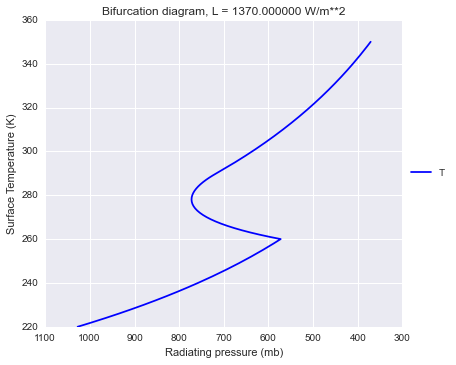

In [11]:
def radPress(flux,T):
    def g(p,const):
        return OLR(const.T,p) - const.flux
    root = newtSolve(g)
    const= Dummy()
    const.T = T
    const.flux = flux
    root.setParams(const)
    return root(500.)


L = 1370.
TList = [220.+i for i in range(131)]
gList = [radPress((1.-albedo(T))*L/4.,T) for T in TList]
cG = Curve()
cG.addCurve(gList,'pRad')
cG.addCurve(TList,'T')
#Just for variety, here I've shown that instead of
# switching axes, you can just put the data into
# the Curve in a different order
cG.PlotTitle = 'Bifurcation diagram, L = %f W/m**2'%L
cG.Ylabel = 'Surface Temperature (K)'
cG.Xlabel = 'Radiating pressure (mb)'
cG.reverseX = True #Reverse pressure axis so warmer is to the right
plot(cG)

### Question 6 ### 
Assume the current climate state is pRad = 670 mb. Where on the diagram do you think we are? (upper or lower branch?). The solar luminosity L was about 7% lower during the Neoproterozoic. ** Would this have been enough to trigger a glaciation? If not, what value of L would have? **

### Answer 6 ###
